# Imports

In [10]:
# Data Processing
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from scipy import interpolate
import numpy as np
import seaborn as sns
from sklearn.preprocessing import normalize


# General
import os
import simplejson as json
import time
import copy


In [11]:
# Custom tools

def fit_line(x, y):
    '''
    Fits a line to an input set of points

    Returns a tuple of the x and y components of the line

    Adapted from: https://stackoverflow.com/a/31800660/6454085
    '''
    return np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x))

def pad_with_zeros(a, new_length):
    '''
    Pads a 1D array with zeros

    If the array is less than the input length it will not be changed
    '''
    a = np.array(a)
    if a.shape[0] >= new_length:
        return a
    else:
        return np.pad(a, (0, new_length-a.shape[0]), mode='constant', constant_values=0)

def remap_array(a, low1, high1, low2, high2):
    '''
    Remaps a numpy array to a specific range
    '''
    return low2 + (high2 - low2) * (a - low1) / (high1 - low1)

def resample(x, n, kind='linear'):
    x = np.array(x)
    f = interpolate.interp1d(np.linspace(0, 1, x.size), x, kind)
    return f(np.linspace(0, 1, n))

    


# Firebase snapshot and other inputs

In [12]:
snapshot_folder = "firebase-snapshots"
snapshot_name = "accessible-teleop-export-9-17-study"


# Load data from Firebase
 The data is loaded from a .json file and converted into a pandas DataFrame, and a dictionary.
 For most of the processing we do, only the pandas dataframe [cycles_df] is necessary.
 It contains cycle-level data about:
 <br>
 - The start and end of a cycle
 - The control scheme that was used
 - The status of the cycle (incomplete or complete)
 - The pose (X, Y, and Theta) of the target

The dictionary [action_list] is organized by interfaceID, and contains all the action chains that made up cycles
It is used to calcuate specific data about specific actions (for example % of time spent orienting vs translating)


In [13]:
json_snapshot = {}
with open(os.path.join(snapshot_folder, snapshot_name + ".json")) as f:
    json_snapshot = json.load(f)
user_data = json_snapshot['users'] 
state_data = json_snapshot['state'] 

# Gather UIDs from states/`interface_num`/completed
uids = []
for interface_num in state_data:
    uids += interface_num['complete'].keys()


In [14]:
# [interfaceIDs] is a set that contains one of each ID
# We use it later on to separate the dataframe by interface
interfaceIDs = set()

cycle_data_columns = ["startTime", "endTime", "status", "control", "transitionType", "interfaceID", "targetX", "targetY", "targetTheta", "threshXY", "threshTheta"]
cycle_data = []

action_list = {}

for uid in user_data:
    if uid in uids:
        for sid in user_data[uid]['sessions']:
            if 'cycles' in user_data[uid]['sessions'][sid]:
                for cid in user_data[uid]['sessions'][sid]['cycles']:
                    cycle = user_data[uid]['sessions'][sid]['cycles'][cid]
                    
                    if 'isTest' not in cycle:
                        continue

                    if cycle['isTest']:
                        # Update cycle_data with general information about the cycle
                        startTime = cycle['startTime']['timestamp'] / 1000
                        status = cycle['status']

                        # There is no end timestamp if the cycle is incomplete
                        endTime = startTime
                        if status == "complete":
                            endTime = cycle['endTime']['timestamp'] / 1000

                        control = cycle['control']
                        transitionType = cycle['transitionType']
                        interfaceID = control + "." +transitionType

                        interfaceIDs.add(interfaceID)

                        targetX = cycle['targetPose']['x']
                        targetY = cycle['targetPose']['y']
                        targetTheta = cycle['targetPose']['theta']
                        threshXY = cycle['targetPose']['threshXY']
                        threshTheta = cycle['targetPose']['threshTheta']

                        cycle_data.append([startTime, endTime, status, control, transitionType, interfaceID, targetX, targetY, targetTheta, threshXY, threshTheta])

                        # Update action_list with the set of actions for this cycle
                        if 'events' in cycle: # Sometimes the last cycle of a session has no action so we skip it
                            actions = []
                            for aid in cycle['events']:

                                # We want to ignore any events that are just ee pose logs, and only keep user actions
                                if cycle['events'][aid]['type'] != 'pose':
                                    # We want to remove any actions that are just a release of the cursor
                                    action_type = cycle['events'][aid]['newState']
                                    if action_type != "cursor-free":
                                        actions.append(action_type)
                                    elif interfaceID == "target.click" or interfaceID == "targetdrag.click":
                                        actions.append(action_type)
                            
                            if interfaceID in action_list:
                                action_list[interfaceID].append(actions)
                            else:
                                action_list[interfaceID] = [actions]


In [15]:
cycles_df = pd.DataFrame(cycle_data, columns=cycle_data_columns)
cycles_df['cycleLength'] = cycles_df['endTime'] - cycles_df['startTime']

# Calculate the euclidean distace between where the ee starts (357, 249) and the target
cycles_df['targetDistance'] = ((cycles_df['targetX'] - 357) ** 2 + (cycles_df['targetY'] - 249) ** 2) ** 0.5
cycles_df = cycles_df[cycles_df["status"] == "complete"]

cycles_df['targetPosTheta'] = np.degrees(np.arccos((cycles_df['targetX'] - 357)/cycles_df['targetDistance']))

interface_dfs = {}
for interfaceID in interfaceIDs:
    interface_dfs[interfaceID] = cycles_df[cycles_df["interfaceID"] == interfaceID]

cycles_df.head()


startTime       endTime    status control transitionType  \
0  1.600298e+09  1.600298e+09  complete    drag  press/release   
1  1.600298e+09  1.600298e+09  complete    drag  press/release   
2  1.600298e+09  1.600298e+09  complete    drag  press/release   
3  1.600298e+09  1.600298e+09  complete    drag  press/release   
4  1.600298e+09  1.600298e+09  complete    drag  press/release   

          interfaceID     targetX     targetY  targetTheta   threshXY  \
0  drag.press/release  274.886793  261.388007  -108.097909  12.219616   
1  drag.press/release  325.406751  280.893333    17.365682  25.499457   
2  drag.press/release  475.381199  335.364216   169.283297   6.276833   
3  drag.press/release  586.054983  251.489435   -35.326347  23.100756   
4  drag.press/release  424.698864  320.086062  -176.326108  13.138039   

   threshTheta  cycleLength  targetDistance  targetPosTheta  
0    28.734672        8.962       83.042408      171.420771  
1    47.212383        5.602       44.892294      134.729180  
2    25.167694       12.742      146.536296       36.112372  
3    53.304350       29.768      229.068510        0.622682  
4    40.994671       10.618       98.164986       46.398088

# Time stats per interface

In [16]:
for interfaceID in interface_dfs:
    interface_df = interface_dfs[interfaceID]

    print(interfaceID)
    print("Mean:", np.mean(interface_df['cycleLength']))
    print("Standard Deviation:",np.std(interface_df['cycleLength']))
    print("Min:",np.min(interface_df['cycleLength']))
    print("Max:",np.max(interface_df['cycleLength']))
    print()



targetdrag.click
Mean: 5.366709877863342
Standard Deviation: 14.621699805384928
Min: 1.3459999561309814
Max: 500.18099999427795

target.click
Mean: 6.605241272184584
Standard Deviation: 10.169995528084801
Min: 1.001000165939331
Max: 251.72399997711182

targetdrag.press/release
Mean: 5.919985270344099
Standard Deviation: 6.408983951869826
Min: 1.0729999542236328
Max: 109.0220000743866

arrow.press/release
Mean: 11.6977384048723
Standard Deviation: 11.826634215066106
Min: 1.5109999179840088
Max: 250.34500002861023

drag.press/release
Mean: 8.917282390261548
Standard Deviation: 17.936943913582812
Min: 1.4689998626708984
Max: 404.17899990081787

arrow.click
Mean: 13.831108426962274
Standard Deviation: 25.673424030206647
Min: 1.4839999675750732
Max: 815.2850000858307

panel.press/release
Mean: 15.260373941945359
Standard Deviation: 15.851828863890256
Min: 1.4149999618530273
Max: 314.914999961853

panel.click
Mean: 19.10566356072638
Standard Deviation: 19.500456722837548
Min: 1.9130001068115

# Time vs. Distance (Euclidean, Orientation, and Combined)
## Euclidean Distance vs Time

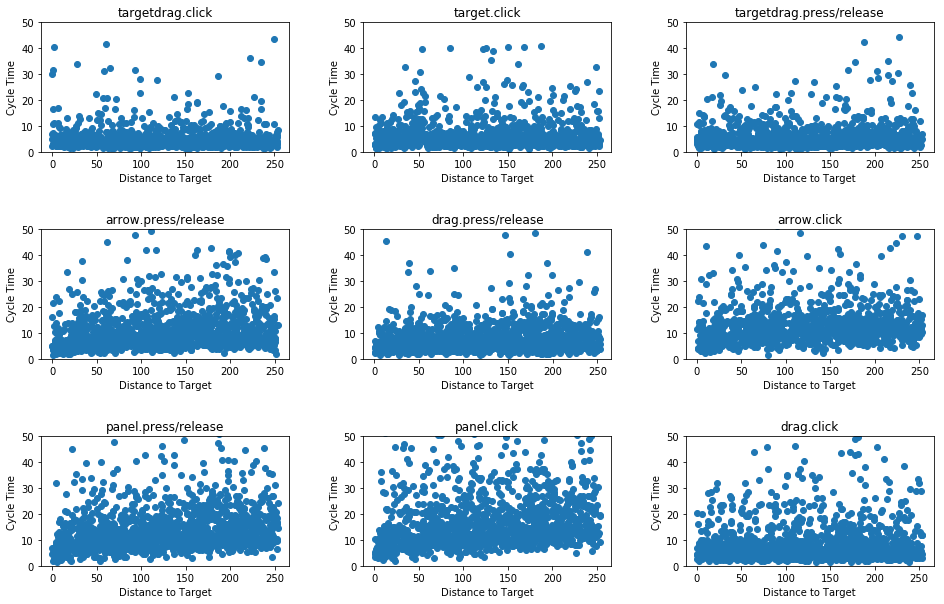

In [17]:
fig = plt.figure(figsize=(16,10))
fig.subplots_adjust(hspace=0.6, wspace=0.3)

for i, interfaceID in enumerate(interface_dfs):
    ax = plt.subplot("33"+str(i+1))
    ax.set_title(interfaceID)
    
    interface_df = interface_dfs[interfaceID]
    ax.scatter(interface_df['targetDistance'], interface_df['cycleLength'], c="tab:blue")
    
    #line = fit_line(interface_df['cycleLength'], interface_df['targetDistance'])
    #ax.plot(line[0], line[1], c="tab:purple")

    ax.set_ylabel('Cycle Time')
    ax.set_xlabel('Distance to Target')

    ax.set_ylim([0, 50])



## Orientation vs Time

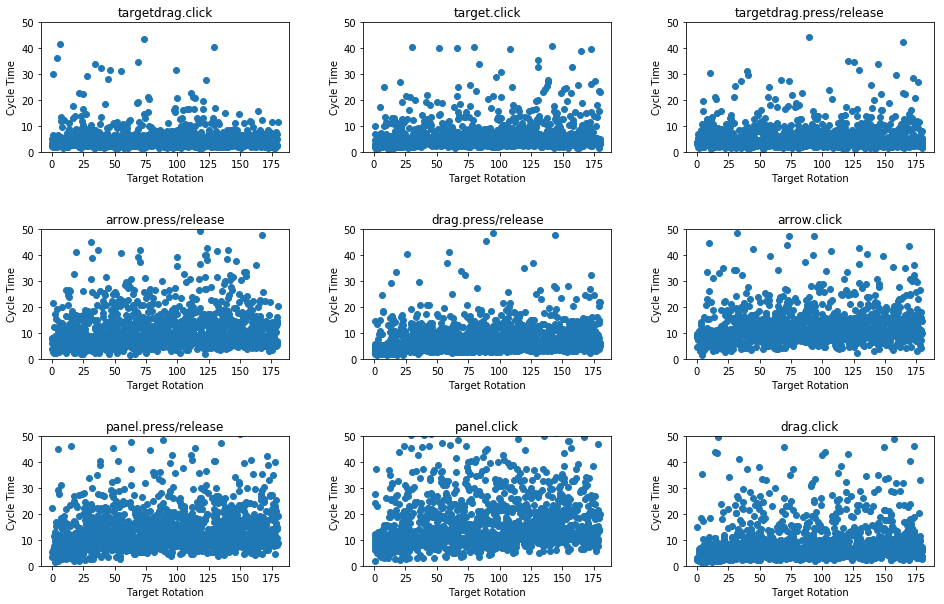

In [18]:
fig = plt.figure(figsize=(16,10))
fig.subplots_adjust(hspace=0.6, wspace=0.3)

for i, interfaceID in enumerate(interface_dfs):
    ax = plt.subplot("33"+str(i+1))
    ax.set_title(interfaceID)
    
    interface_df = interface_dfs[interfaceID]
    ax.scatter(np.abs(interface_df['targetTheta']), interface_df['cycleLength'], c="tab:blue")
    
    #line = fit_line(interface_df['cycleLength'], np.abs(interface_df['targetTheta']))
    #ax.plot(line[0], line[1], c="tab:purple")

    ax.set_ylabel('Cycle Time')
    ax.set_xlabel('Target Rotation')

    ax.set_ylim([0, 50])


## Distance + Orientation vs Time

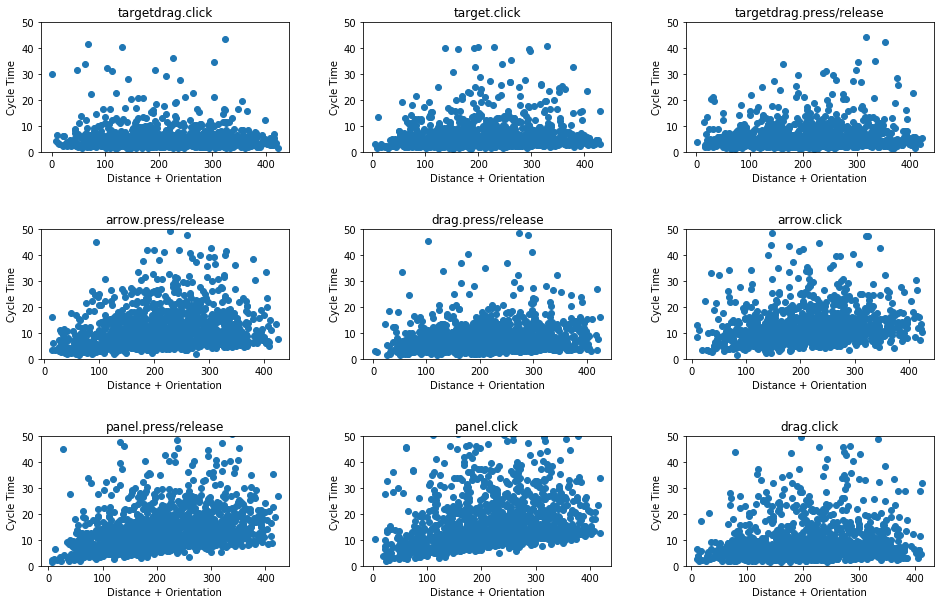

In [19]:

fig = plt.figure(figsize=(16,10))
fig.subplots_adjust(hspace=0.6, wspace=0.3)

for i, interfaceID in enumerate(interface_dfs):
    ax = plt.subplot("33"+str(i+1))
    ax.set_title(interfaceID)
    
    interface_df = interface_dfs[interfaceID]#
    ax.scatter(np.abs(interface_df['targetTheta']) + interface_df['targetDistance'], interface_df['cycleLength'], c="tab:blue")
    
    #line = fit_line(interface_df['cycleLength'], np.abs(interface_df['targetTheta']) + interface_df['targetDistance'])
    #ax.plot(line[0], line[1], c="tab:purple")

    ax.set_ylabel('Cycle Time')
    ax.set_xlabel('Distance + Orientation')

    ax.set_ylim([0, 50])


## Distance / Time / Flex Correlation

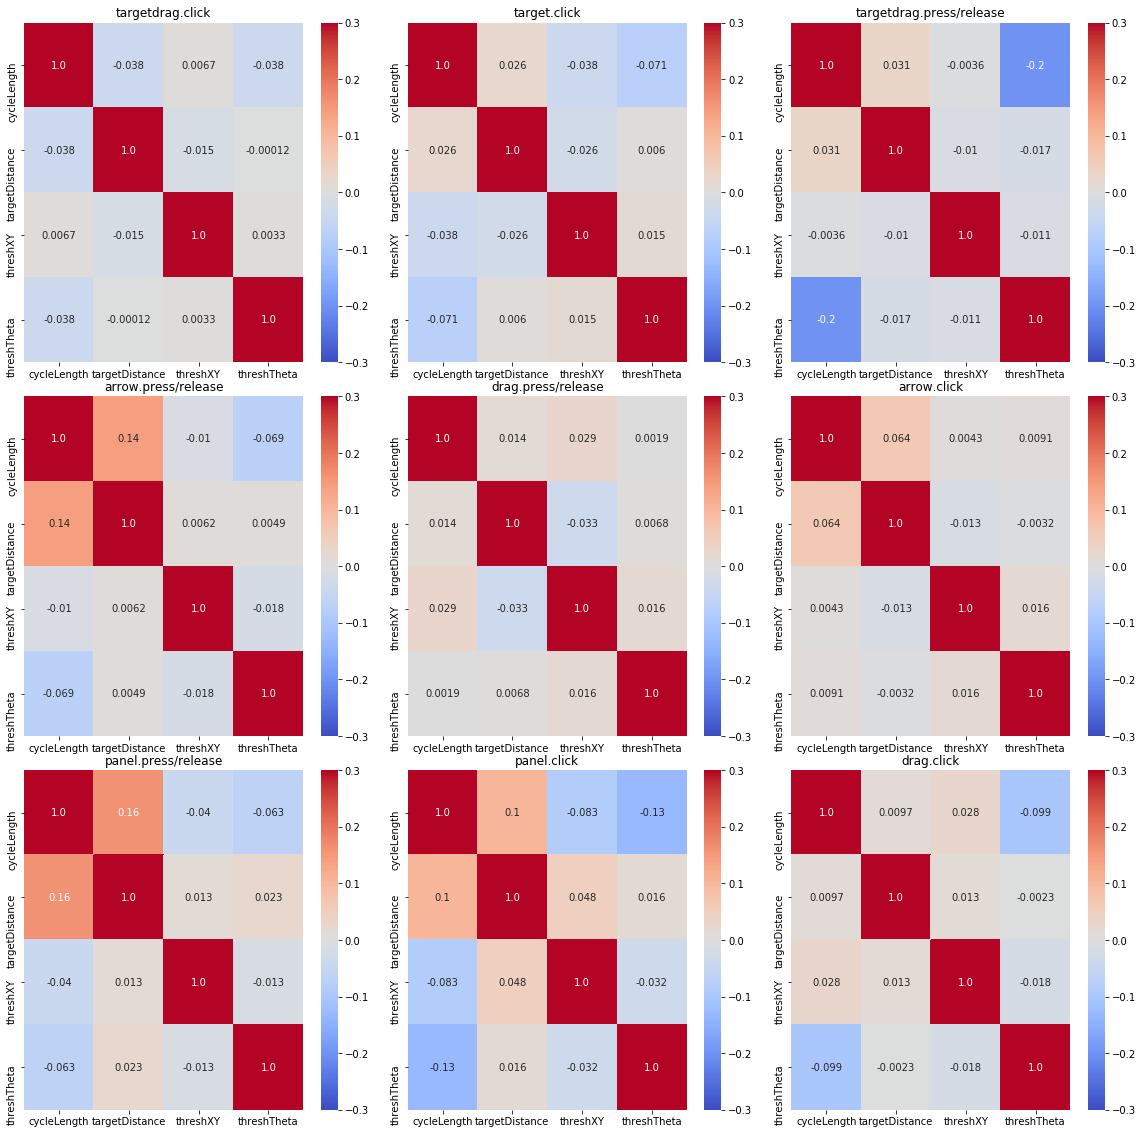

In [20]:
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, interfaceID in enumerate(interface_dfs):
    ax = plt.subplot("33"+str(i+1))
    ax.set_title(interfaceID)

    interface_df = interface_dfs[interfaceID]
    
    corr_matrix = interface_df[['cycleLength', 'targetDistance', 'threshXY', 'threshTheta']].corr()
    sns.heatmap(corr_matrix, annot = True, fmt='.2',cmap= 'coolwarm', ax=ax, vmin=-0.3, vmax=0.3)
plt.show()


## Cycle Time vs Target Position Angle
 Target Position Angle is the angle made between the location of the target and the center.
 A target all straight right would have an angel of 0, touching the top would be 90, etc.

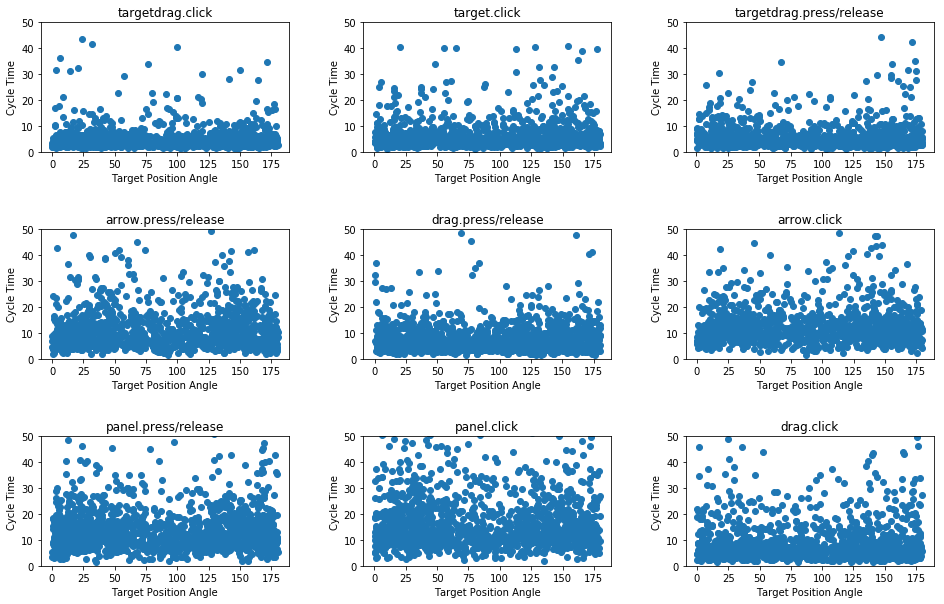

In [21]:
fig = plt.figure(figsize=(16,10))
fig.subplots_adjust(hspace=0.6, wspace=0.3)

for i, interfaceID in enumerate(interface_dfs):
    ax = plt.subplot("33"+str(i+1))
    ax.set_title(interfaceID)

    interface_df = interface_dfs[interfaceID]
    ax.scatter(interface_df['targetPosTheta'], interface_df['cycleLength'], c="tab:blue")
    
    #line = fit_line(interface_df['cycleLength'], np.abs(interface_df['targetTheta']) + interface_df['targetDistance'])
    #ax.plot(line[0], line[1], c="tab:purple")

    ax.set_xlabel('Target Position Angle')
    ax.set_ylabel('Cycle Time')

    
    ax.set_ylim([0, 50])
plt.show()
